In [354]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import seaborn as sns

from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.spatial.distance import cdist
from scipy.spatial import ConvexHull

import itertools
import random

from utils import *
from collections import Counter

plt.style.use('seaborn-darkgrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

np.random.seed(260647775)

In [2]:
def condition(coord):
    x, y = coord
    
    return (x-25)**2 + (y-25)**2 < 225 # radius 15

grid      = [[(x, y) for y in range(50)] for x in range(50)]
grayscale = [[2 if condition(tup) else 0.5 for tup in row] for row in grid]

In [3]:
noise = np.random.normal(0, 0.7, size=(50, 50))

In [4]:
noisy_image = grayscale - noise
#np.putmask(noisy_image, noisy_image < 0, 0)
#np.putmask(noisy_image, noisy_image > 1, 1)

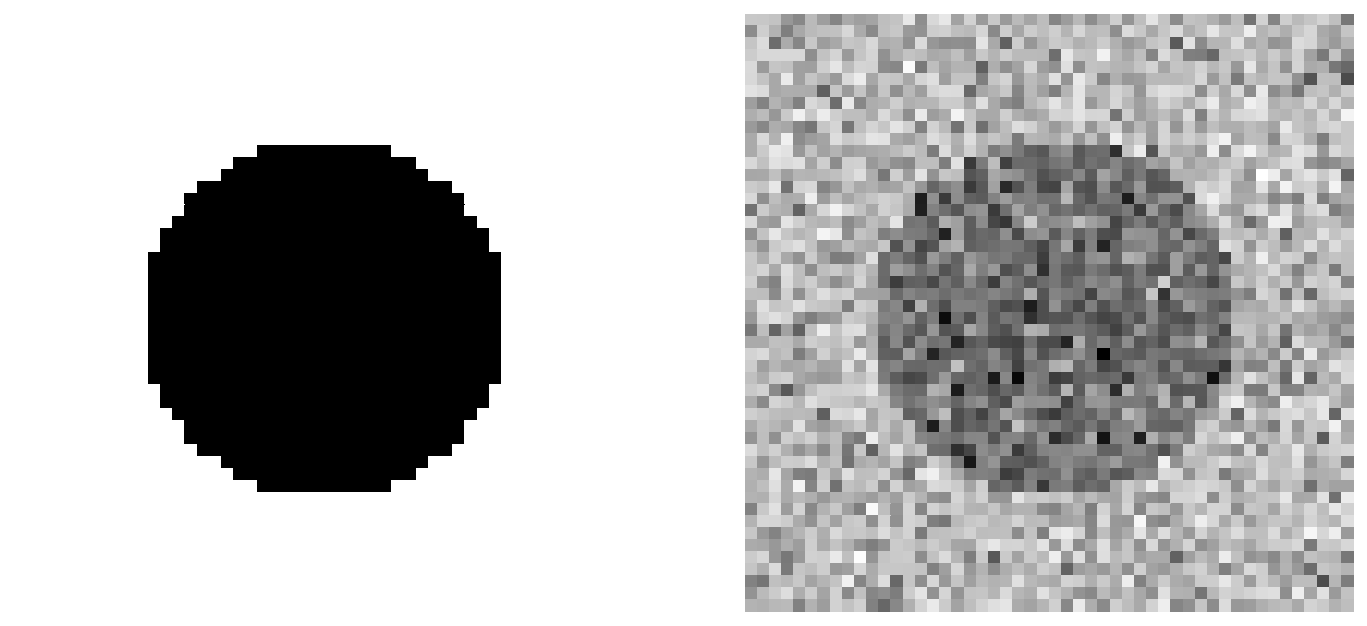

In [5]:
fig, axes = plt.subplots(figsize=(12, 5.5), nrows=1, ncols=2)

axes[0] = sns.heatmap(grayscale,
                        cmap='Greys',
                        cbar=False,
                        xticklabels='',
                        yticklabels='',
                        ax=axes[0])
plt.axis('off')
axes[1] = sns.heatmap(noisy_image,
                      cmap='Greys',
                      cbar=False,
                      xticklabels='',
                      yticklabels='',
                      ax=axes[1])

#### Initialization of random points

In [269]:
num_points = 12
points = random_tessellation_points(num_points)

In [270]:
vor = Voronoi(points)
regions, vertices = voronoi_finite_polygons_2d(vor)
updated_vertices = {i: restricted_vertices(vertices[regions[i]], points[i]) for i in range(len(points))}

In [271]:
# manually add corners somewhere
# order no longer matters
for corner in [(0, 0), (0, 50), (50, 0), (50, 50)]:
    
    region_where_corner_belongs = np.argmin([l2_norm(p, corner) for p in points])
    temp_vertices = updated_vertices[region_where_corner_belongs].copy()
    
    updated_vertices[region_where_corner_belongs] = np.array(list(temp_vertices) + [corner] )

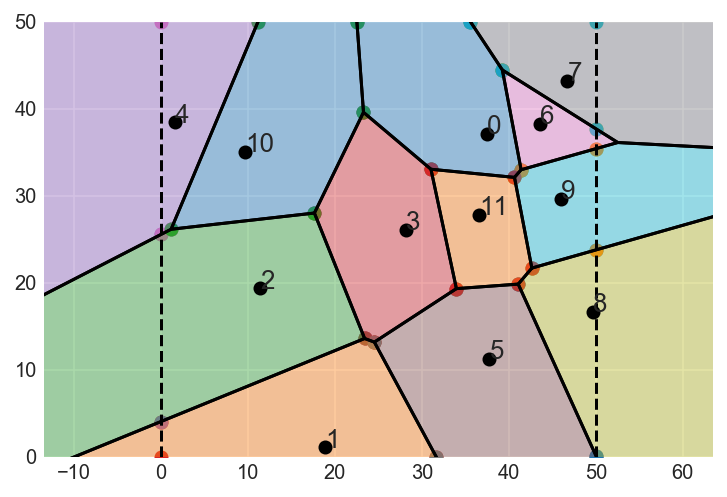

In [272]:
fig = plt.figure(figsize=(10, 7))
plot(points)

for i, region in enumerate(regions):
    try:
        a, b = zip(*updated_vertices[i])
        plt.scatter(a, b)
    except Exception as e:
        pass

In [273]:
total_area = 0
for i in range(num_points):
    print('{}th region: {} vertices\t area = {}'.format(i, len(updated_vertices[i]), PolyArea(updated_vertices[i])))
    total_area += PolyArea(updated_vertices[i])
print('Total area: ', np.around(total_area, 3))

0th region: 7 vertices	 area = 256.3336943590548
1th region: 5 vertices	 area = 267.8633801929406
2th region: 5 vertices	 area = 389.9048234731315
3th region: 6 vertices	 area = 260.7896658987538
4th region: 4 vertices	 area = 147.26991652097936
5th region: 6 vertices	 area = 334.60572390164987
6th region: 4 vertices	 area = 64.21022769694582
7th region: 4 vertices	 area = 106.18856006471697
8th region: 4 vertices	 area = 110.71136422294921
9th region: 5 vertices	 area = 97.80975822023538
10th region: 5 vertices	 area = 346.05019829765524
11th region: 5 vertices	 area = 118.26268715098695
Total area:  2500.0


#### Constants


In [429]:
lam = 15 # lambda
alpha = 1 # alpha
beta  = 1 # beta
sigma = 0.7
k = truncated_poisson(lam=lam, size=1)[0]

coordinates = np.array([[(i + 0.5, j + 0.5) for i in range(50)] for j in range(50)])
coordinates = coordinates.reshape(-1, 2)

#### Sampler

In [430]:
class UpdatedVoronoi:
    def __init__(self, _points):
        self.points = _points
        self.vor = Voronoi(_points)
        self.regions, self.vertices = voronoi_finite_polygons_2d(self.vor)
        

        self.areas = np.array([PolyArea(self.updated_vertices[i]) for i in range(len(_points))]) # hashable
        self.x_heights = [] # indices
        
        coordinates = np.array([[(i + 0.5, j + 0.5) for i in range(50)] for j in range(50)])
        coordinates = coordinates.reshape(-1, 2)

        for (u, v) in coordinates:
            self.x_heights.append(np.argmin(cdist(_points, [[u, v]]).reshape(-1,)))
    
    @property
    def updated_vertices(self):
        new_vertices = {i: restricted_vertices(self.vertices[self.regions[i]], self.points[i]) for i in range(len(self.points))}

        for corner in [(0, 0), (0, 50), (50, 0), (50, 50)]:

            region_where_corner_belongs = np.argmin([l2_norm(p, corner) for p in self.points])
            temp_vertices = new_vertices[region_where_corner_belongs].copy()

            new_vertices[region_where_corner_belongs] = np.array(list(temp_vertices) + [corner])
            
        return new_vertices
    
    
def get_neighbors(updated_vor, i):
    # not working...
    assert i in updated_vor.updated_vertices.keys()
    
    i_vertices = updated_vor.updated_vertices[i]
    neighbors  = []
    
    for j in range(len(updated_vor.points)):
        
        if i == j:
            continue
            
        j_vertices = updated_vor.updated_vertices[j] # temp
        
        x_intersects = np.intersect1d(i_vertices[:, 0], j_vertices[:, 0])
        y_intersects = np.intersect1d(i_vertices[:, 1], j_vertices[:, 1])
        
        same_x_coord = np.array([_i for (_i, x) in enumerate(x_intersects) if x in i_vertices])
        same_y_coord = np.array([_j for (_j, x) in enumerate(y_intersects) if x in j_vertices])
        
        if same_x_coord != []:
            vertices_in_common = np.intersect1d(same_x_coord, same_y_coord)
            
            if len(vertices_in_common) == len(same_x_coord):
                #assert len(vertices_in_common) == 2
                neighbors.append(j)
            
    return np.array(neighbors)

In [431]:
NUM_ITER = 20000

In [432]:
points  = random_tessellation_points(k)
old_Voronoi = UpdatedVoronoi(points)

In [489]:
x_sample = []
k_sample = []

count = 0
death = 0
birth = 0
while len(x_sample) < 200:

    if count % 100 == 0:
        print('Done sampling ', count)
    
    points  = random_tessellation_points(k)
    old_Voronoi = UpdatedVoronoi(points)
    
    counter = Counter(old_Voronoi.x_heights)
    ni = np.array([counter[r] for r in range(k)])
    sum_yi = np.array([sum(noisy_image.reshape(-1)[np.argwhere(np.array(old_Voronoi.x_heights) == r).reshape(-1)]) for r in range(k)])
    
    heights = np.random.normal(loc=(sum_yi + 0.7**2)/ni, scale=np.sqrt(0.7**2/ni))
    
    if any(heights <= 0):
        invalid_heights = np.argwhere(heights <= 0).reshape(-1)
        heights[invalid_heights] = 0.1 # sketchy solution

    new_point   = np.random.uniform(low=0, high=50, size=[1, 2])
    temp_points = np.concatenate((points, new_point.reshape(1, 2)))
    new_Voronoi = UpdatedVoronoi(temp_points)

#    J = get_neighbors(new_Voronoi, k) # k is last index of new voronoi, J as defined in Green (1995)
    diff_areas = (old_Voronoi.areas - new_Voronoi.areas[:-1])
    J = np.argwhere(diff_areas > 1e-7).reshape(-1).astype(np.int32)
    
#    assert all(np.argwhere(diff_areas > 1e-7).reshape(-1).astype(np.int32) == np.sort(J))

    S, T = diff_areas[J], new_Voronoi.areas[J] # change in areas, new areas

    assert np.abs(sum(S) - new_Voronoi.areas[-1]) < 1e-7 # change in areas same as area of new region

    v = inverse_v(np.random.uniform(0, 1)) # ~ f(v)
    h_tilde = np.exp(1/sum(S)*(S@np.log(heights[J]))) # no worries about height = 0
    h_star  = h_tilde*v
    heights = np.array(list(heights) + [h_star])

    new_heights  = heights[J]**(1+S/T)*(np.tile(h_star, len(J))**(-S/T))
    loglikeratio = log_likelihood_ratio(noisy_image.reshape(-1,), 
                                        heights[new_Voronoi.x_heights], 
                                        heights[old_Voronoi.x_heights])
    # check if R < or > than 0
    logR = loglikeratio + \
           np.log(lam) - \
           h_star - \
           sum(new_heights - heights[J]) - \
           np.log(poisson_ratio_pdf(k)*h_tilde/f(v)) - \
           np.log(sum((S+T)*new_heights/(T*heights[J])))



    if logR < 0:
        if np.random.binomial(n=1, p=np.exp(logR)):
            birth += 1
            
            heights[J] = new_heights
            assert len(heights) == max(new_Voronoi.x_heights) + 1 # birth

            k = k+1
            x_sample.append(heights[new_Voronoi.x_heights])
            k_sample.append(k)
            
        else:
            x_sample.append(heights[old_Voronoi.x_heights])
            k_sample.append(k)

    else:
        if np.random.binomial(n=1, p=np.exp(-logR)):
            death += 1
            
            heights = heights[:-1] # removing h_star
            

            delete_tile = random.choice(range(len(points)))
            temp_points = np.delete(points, delete_tile, axis=0)

            new_Voronoi = UpdatedVoronoi(temp_points)

            J = get_neighbors(old_Voronoi, delete_tile) # tile no longer exists in new_Voronoi
            _temp_areas = np.insert(new_Voronoi.areas, delete_tile, 0)
            diff_areas  = (_temp_areas - old_Voronoi.areas)

            S, T = diff_areas[J], old_Voronoi.areas[J] # change in areas, new areas

            assert np.abs(sum(S) - old_Voronoi.areas[delete_tile]) < 1e-7 # change in areas same as area of new region

            v = inverse_v(np.random.uniform(0, 1))
            h_tilde = np.exp(1/sum(S)*(S@np.log(heights[J]))) # no worries about height = 0
            h_star  = h_tilde*v
            #height
            s = np.insert(heights, delete_tile, 0)

            new_heights  = heights[J]**(T/(S+T))*(h_star**(S/(S+T)))
            heights[J] = new_heights
            heights = np.delete(heights, delete_tile)

            assert len(heights) == max(new_Voronoi.x_heights) + 1 # death
            
            k = k-1
            x_sample.append(heights[new_Voronoi.x_heights])
            k_sample.append(k)
        
        else:
            x_sample.append(heights[old_Voronoi.x_heights])
            k_sample.append(k)

    count += 1

Done sampling  0


/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


Done sampling  20
Done sampling  40
Done sampling  60
Done sampling  80
Done sampling  100
Done sampling  120


/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less_equal


Done sampling  140
Done sampling  160
Done sampling  180


Below for debugging purposes

In [297]:
i_vertices = new_Voronoi.updated_vertices[k]
neighbors  = []

for j in range(len(new_Voronoi.points)):

    if k == j:
        continue

    j_vertices = new_Voronoi.updated_vertices[j] # temp

    x_intersects = np.intersect1d(i_vertices[:, 0], j_vertices[:, 0])
    y_intersects = np.intersect1d(i_vertices[:, 1], j_vertices[:, 1])

    same_x_coord = np.array([_i for (_i, x) in enumerate(x_intersects) if x in i_vertices])
    same_y_coord = np.array([_j for (_j, x) in enumerate(y_intersects) if x in j_vertices])

    if same_x_coord != []:
        vertices_in_common = np.intersect1d(same_x_coord, same_y_coord)

        if len(vertices_in_common) == len(same_x_coord):
            #assert len(vertices_in_common) == 2
            neighbors.append(j)

/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


In [439]:
points.shape, temp_points.shape

((14, 2), (15, 2))

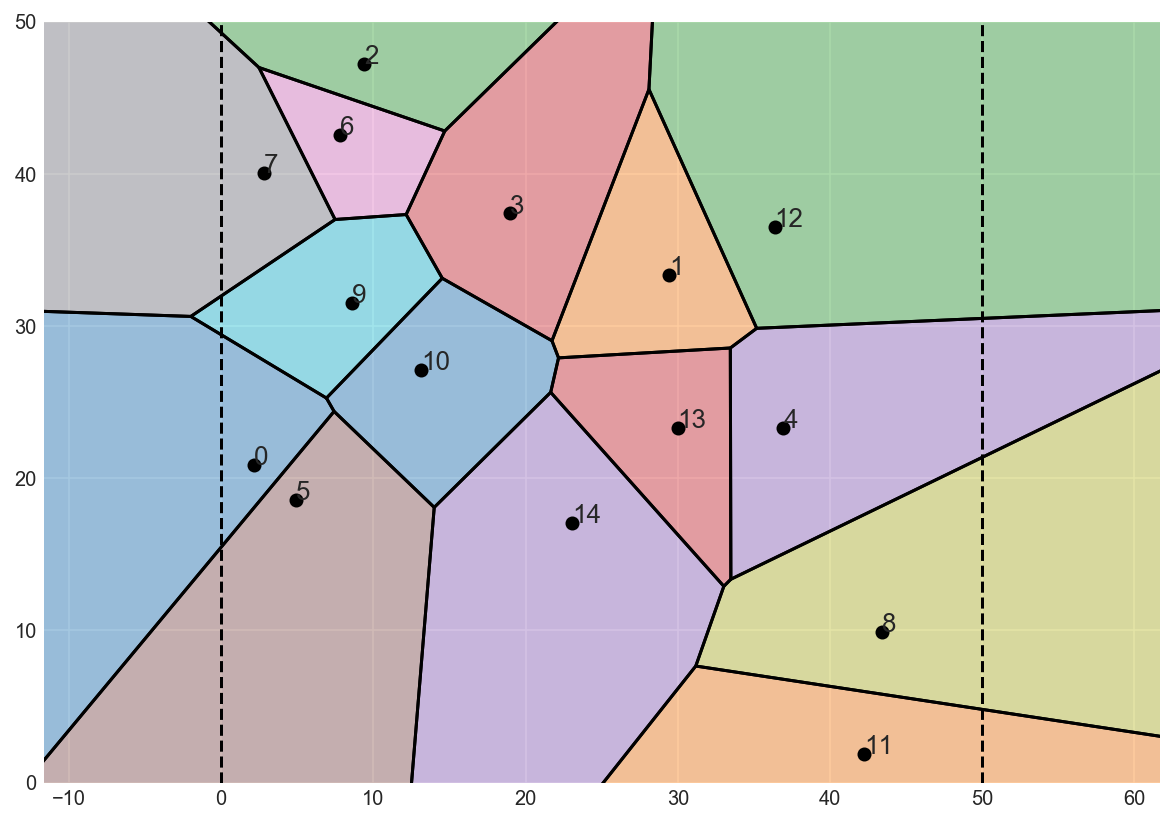

In [476]:
fig = plt.figure(figsize=(10, 7))
plot(points)

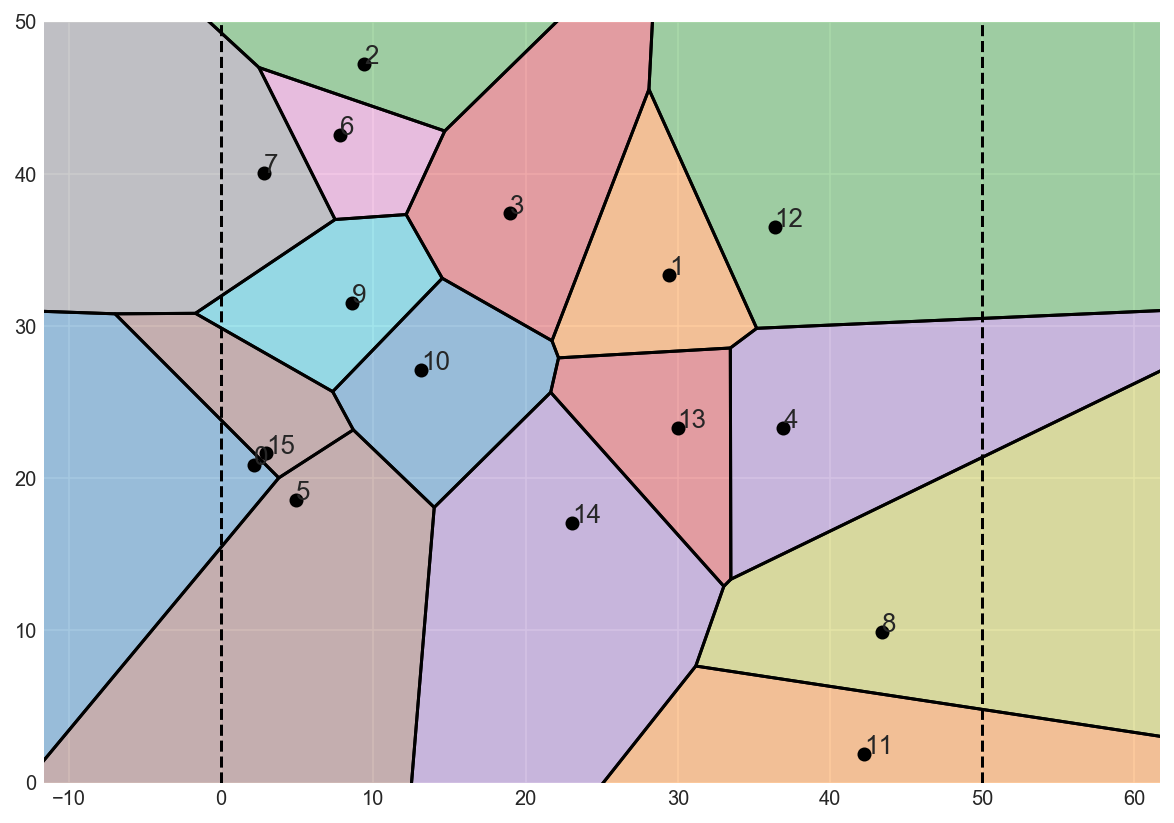

In [477]:
fig = plt.figure(figsize=(10, 7))
plot(temp_points)

Text(0.5, 1.0, 'Image with no noise')

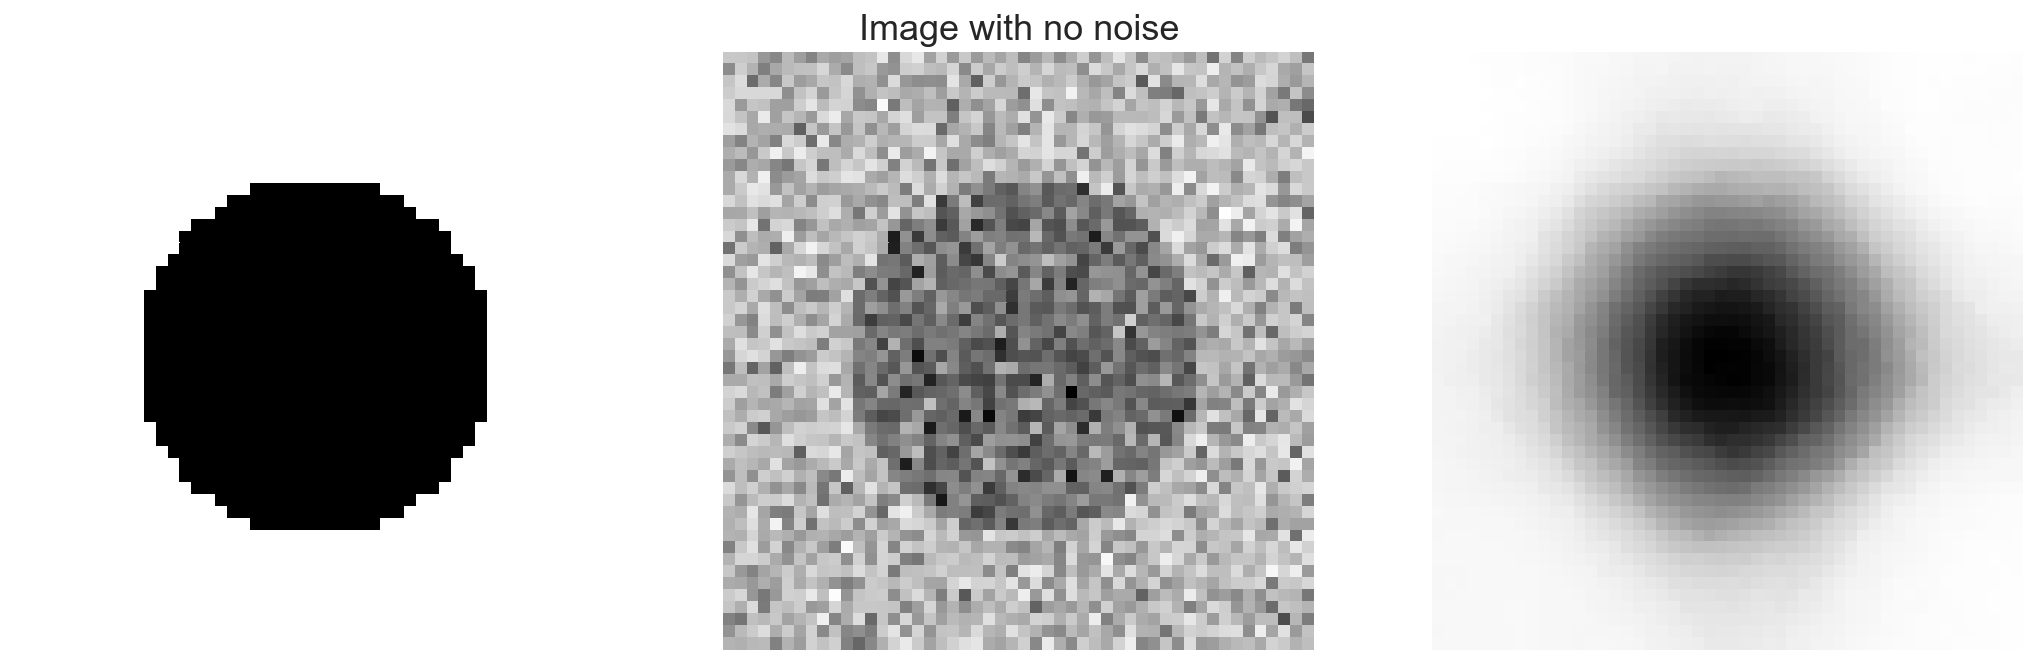

In [503]:
fig, axes = plt.subplots(figsize=(18, 5.5), nrows=1, ncols=3)
axes[0] = sns.heatmap(grayscale,
                        cmap='Greys',
                        cbar=False,
                        xticklabels='',
                        yticklabels='',
                        ax=axes[0])
plt.axis('off')
axes[1] = sns.heatmap(noisy_image,
                      cmap='Greys',
                      cbar=False,
                      xticklabels='',
                      yticklabels='',
                      ax=axes[1])

axes[2] = sns.heatmap(np.mean(x_sample, axis=0).reshape(50, 50), 
                      cmap='Greys',
                      cbar=False,
                      xticklabels='',
                      yticklabels='',
                      ax=axes[2])

axes[0].set_title('Image with no noise', fontsize=18)
axes[1].set_title('Image with added noise', fontsize=18)
axes[2].set_title('Deblurred image', fontsize=18)

In [ ]:
np.save()